# Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from pandas import date_range
from sklearn.model_selection import TimeSeriesSplit
import random

In [ ]:
train = pd.read_csv('dataset_sensor_11d.csv')
train.drop(columns='id',inplace=True)
train['timestamp'] = pd.to_datetime(train.timestamp)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7127 entries, 0 to 7126
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7127 non-null   datetime64[ns]
 1   temp       7127 non-null   float64       
 2   hum        7127 non-null   float64       
 3   pre        7127 non-null   float64       
 4   co         7127 non-null   float64       
 5   pm2_5      7127 non-null   int64         
 6   no2        7127 non-null   float64       
 7   pm1        7127 non-null   int64         
 8   o3         7127 non-null   float64       
 9   pm10       7127 non-null   int64         
 10  aqi        2539 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 612.6 KB


## Preprocessing


### Data Indexing and Resampling



In [ ]:
train = train.set_index('timestamp')
train = train.resample('10T').last()
n = len(train)

In [ ]:
train

,temp,hum,pre,co,pm2_5,no2,pm1,o3,pm10,aqi
timestamp,,,,,,,,,,
2023-11-20 23:20:00,29.51,50.1162,1008.83,469.938,9.0,14.5057,7.0,113.8650,10.0,NaN
2023-11-20 23:30:00,30.11,45.9590,1008.82,469.099,9.0,14.5709,7.0,123.6810,10.0,NaN
2023-11-20 23:40:00,30.58,45.0508,1008.69,473.954,10.0,14.5743,8.0,121.7180,11.0,NaN
2023-11-20 23:50:00,30.50,44.2295,1008.60,486.633,9.0,14.5555,7.0,117.7910,10.0,NaN
2023-11-21 00:00:00,30.67,43.2998,1008.52,469.484,8.0,14.5263,6.0,115.8280,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-11-30 20:40:00,31.52,48.1787,1009.94,281.436,49.0,12.7054,40.0,62.8221,55.0,67.0
2023-11-30 20:50:00,31.74,48.3154,1010.03,287.443,47.0,12.6705,38.0,62.8221,53.0,67.0
2023-11-30 21:00:00,31.97,48.3594,1010.12,282.693,47.0,12.7831,38.0,64.7853,53.0,67.0


### Checking Outliers and Remove Outliers

<Axes: >

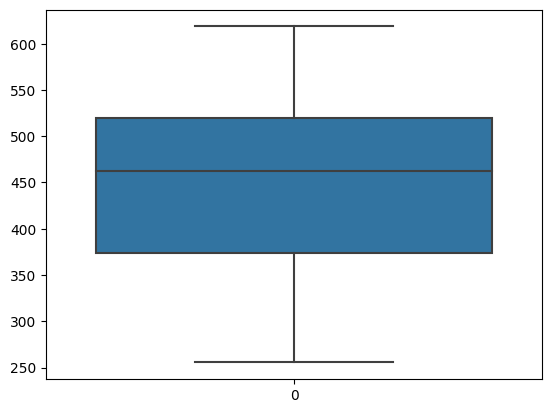

In [ ]:
sns.boxplot(train['co'])

<Axes: >

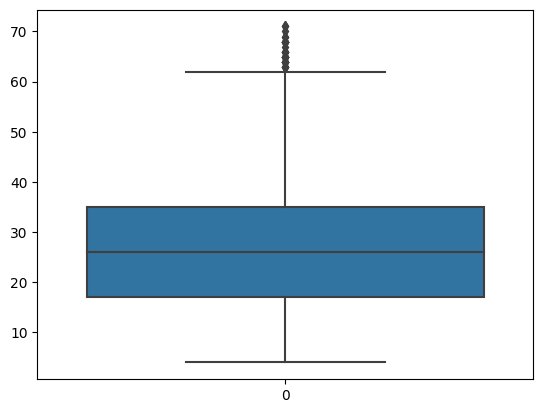

In [ ]:
sns.boxplot(train['pm10'])

<Axes: >

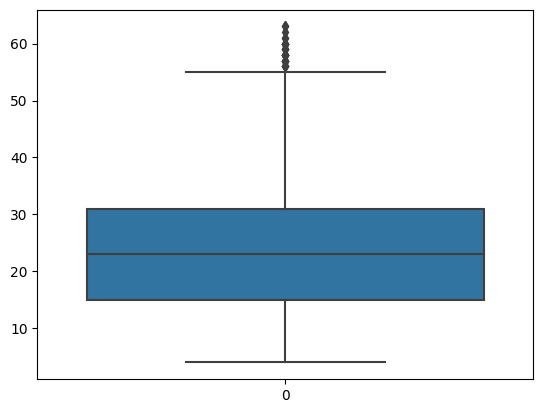

In [ ]:
sns.boxplot(train['pm2_5'])

<Axes: >

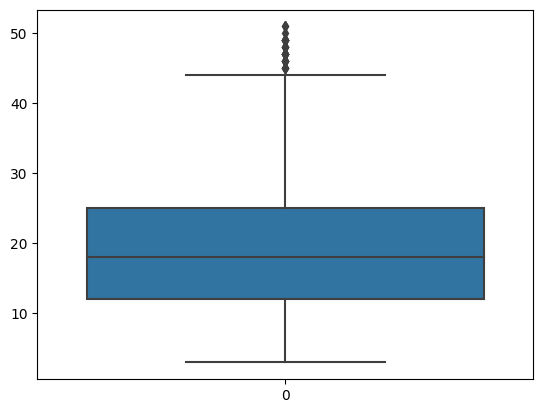

In [ ]:
sns.boxplot(train['pm1'])

<Axes: >

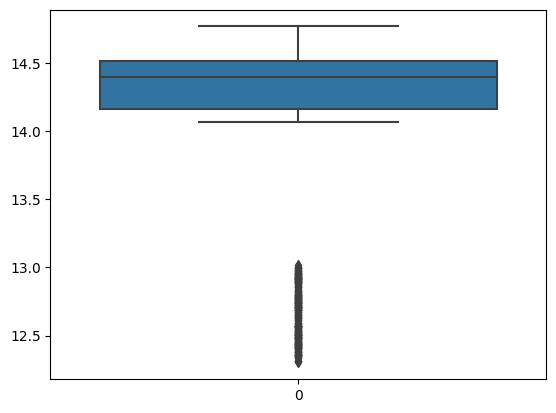

In [ ]:
sns.boxplot(train['no2'])

<Axes: >

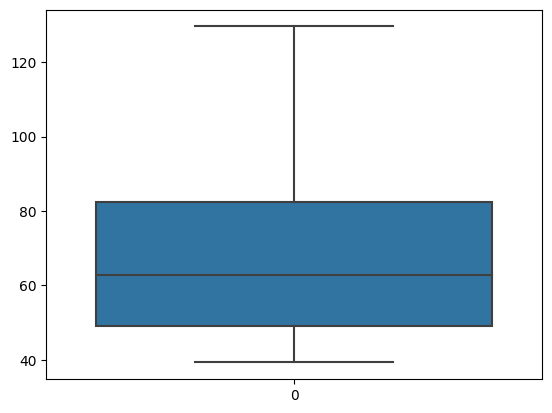

In [ ]:
train = train[train['o3'] < 130]
sns.boxplot(train['o3'])

### Time Series Split

In [ ]:
df_train = train.iloc[:int(n*0.9)]
df_test = train.iloc[int(n*0.9):]

In [ ]:
train_co = df_train[['co']]
train_pm25 = df_train[['pm2_5']]
train_no2 = df_train[['no2']]
train_pm1 = df_train[['pm1']]
train_o3 = df_train[['o3']]
train_pm10 = df_train[['pm10']]


test_co = df_test[['co']]
test_pm25 = df_test[['pm2_5']]
test_no2 = df_test[['no2']]
test_pm1 = df_test[['pm1']]
test_o3 = df_test[['o3']]
test_pm10 = df_test[['pm10']]

## Feature Engineering

In [ ]:
def create_feature(df, column):
    for lag in range(1, 4):
        df[f'lag_{lag}'] = df[column].shift(lag)
    df[f'{column}_rolling_mean'] = df[column].rolling(window=3).mean().shift(1)
    df[f'{column}_rolling_std'] = df[column].rolling(window=3).std().shift(1)

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['minute'] = df.index.minute
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day

In [ ]:
create_feature(train_co, 'co')
create_feature(train_pm25, 'pm2_5')
create_feature(train_no2, 'no2')
create_feature(train_pm1, 'pm1')
create_feature(train_o3, 'o3')
create_feature(train_pm10, 'pm10')


create_feature(test_co, 'co')
create_feature(test_pm25, 'pm2_5')
create_feature(test_no2, 'no2')
create_feature(test_pm1, 'pm1')
create_feature(test_o3, 'o3')
create_feature(test_pm10, 'pm10')

<ipython-input-14-94127460186c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df[column].shift(lag)
<ipython-input-14-94127460186c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df[column].shift(lag)
<ipython-input-14-94127460186c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [ ]:
train_co

,co,lag_1,lag_2,lag_3,co_rolling_mean,co_rolling_std,hour,dayofweek,quarter,month,year,minute,dayofyear,dayofmonth
timestamp,,,,,,,,,,,,,,
2023-11-20 23:20:00,469.938,NaN,NaN,NaN,NaN,NaN,23,0,4,11,2023,20,324,20
2023-11-20 23:30:00,469.099,469.938,NaN,NaN,NaN,NaN,23,0,4,11,2023,30,324,20
2023-11-20 23:40:00,473.954,469.099,469.938,NaN,NaN,NaN,23,0,4,11,2023,40,324,20
2023-11-20 23:50:00,486.633,473.954,469.099,469.938,470.997000,2.594970,23,0,4,11,2023,50,324,20
2023-11-21 00:00:00,469.484,486.633,473.954,469.099,476.562000,9.053261,0,1,4,11,2023,0,325,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30 12:00:00,270.189,269.002,266.452,270.853,268.769000,2.209732,12,3,4,11,2023,0,334,30
2023-11-30 12:10:00,270.958,270.189,269.002,266.452,268.547667,1.909478,12,3,4,11,2023,10,334,30
2023-11-30 12:20:00,272.390,270.958,270.189,269.002,270.049667,0.985416,12,3,4,11,2023,20,334,30


In [ ]:
train_co.dropna(inplace=True)
train_o3.dropna(inplace=True)
train_pm1.dropna(inplace=True)
train_no2.dropna(inplace=True)
train_pm25.dropna(inplace=True)
train_pm10.dropna(inplace=True)

test_co.dropna(inplace=True)
test_o3.dropna(inplace=True)
test_pm1.dropna(inplace=True)
test_no2.dropna(inplace=True)
test_pm25.dropna(inplace=True)
test_pm10.dropna(inplace=True)

In [ ]:
train_co

,co,lag_1,lag_2,lag_3,co_rolling_mean,co_rolling_std,hour,dayofweek,quarter,month,year,minute,dayofyear,dayofmonth
timestamp,,,,,,,,,,,,,,
2023-11-20 23:50:00,486.633,473.954,469.099,469.938,470.997000,2.594970,23,0,4,11,2023,50,324,20
2023-11-21 00:00:00,469.484,486.633,473.954,469.099,476.562000,9.053261,0,1,4,11,2023,0,325,21
2023-11-21 00:10:00,474.269,469.484,486.633,473.954,476.690333,8.895937,0,1,4,11,2023,10,325,21
2023-11-21 00:20:00,473.326,474.269,469.484,486.633,476.795333,8.849227,0,1,4,11,2023,20,325,21
2023-11-21 00:30:00,469.763,473.326,474.269,469.484,472.359667,2.534641,0,1,4,11,2023,30,325,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30 12:00:00,270.189,269.002,266.452,270.853,268.769000,2.209732,12,3,4,11,2023,0,334,30
2023-11-30 12:10:00,270.958,270.189,269.002,266.452,268.547667,1.909478,12,3,4,11,2023,10,334,30
2023-11-30 12:20:00,272.390,270.958,270.189,269.002,270.049667,0.985416,12,3,4,11,2023,20,334,30


# Forecasting New Data

In [ ]:
train_copy = train.copy()
train_copy

,temp,hum,pre,co,pm2_5,no2,pm1,o3,pm10,aqi
timestamp,,,,,,,,,,
2023-11-20 23:20:00,29.51,50.1162,1008.83,469.938,9.0,14.5057,7.0,113.8650,10.0,NaN
2023-11-20 23:30:00,30.11,45.9590,1008.82,469.099,9.0,14.5709,7.0,123.6810,10.0,NaN
2023-11-20 23:40:00,30.58,45.0508,1008.69,473.954,10.0,14.5743,8.0,121.7180,11.0,NaN
2023-11-20 23:50:00,30.50,44.2295,1008.60,486.633,9.0,14.5555,7.0,117.7910,10.0,NaN
2023-11-21 00:00:00,30.67,43.2998,1008.52,469.484,8.0,14.5263,6.0,115.8280,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-11-30 20:40:00,31.52,48.1787,1009.94,281.436,49.0,12.7054,40.0,62.8221,55.0,67.0
2023-11-30 20:50:00,31.74,48.3154,1010.03,287.443,47.0,12.6705,38.0,62.8221,53.0,67.0
2023-11-30 21:00:00,31.97,48.3594,1010.12,282.693,47.0,12.7831,38.0,64.7853,53.0,67.0


In [ ]:
train_copy_co = train_copy[['co']]
create_feature(train_copy_co, 'co')

train_copy_pm25 = train_copy[['pm2_5']]
create_feature(train_copy_pm25, 'pm2_5')

train_copy_no2 = train_copy[['no2']]
create_feature(train_copy_no2, 'no2')

train_copy_pm1 = train_copy[['pm1']]
create_feature(train_copy_pm1, 'pm1')

train_copy_o3 = train_copy[['o3']]
create_feature(train_copy_o3, 'o3')

train_copy_pm10 = train_copy[['pm10']]
create_feature(train_copy_pm10, 'pm10')

<ipython-input-14-94127460186c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df[column].shift(lag)
<ipython-input-14-94127460186c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{lag}'] = df[column].shift(lag)
<ipython-input-14-94127460186c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [ ]:
train_copy_co.dropna(inplace=True)
train_copy_pm25.dropna(inplace=True)
train_copy_no2.dropna(inplace=True)
train_copy_pm1.dropna(inplace=True)
train_copy_o3.dropna(inplace=True)
train_copy_pm10.dropna(inplace=True)

**1. Memprediksi CO**

In [ ]:
X_train_copy_co = train_copy_co.drop(columns=['co'])
y_train_copy_co = train_copy_co['co']

In [ ]:
model_co =  xgb.XGBRegressor()
model_co.fit(X_train_copy_co, y_train_copy_co)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-24-235cb9644556>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_co = df_forecast_co.append(new_row)
<ipython-input-24-235cb9644556>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_co = df_forecast_co.append(new_row)
<ipython-input-24-235cb9644556>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_co = df_forecast_co.append(new_row)
<ipython-input-24-235cb9644556>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_co = df_forecast_co.append(new_row)
<ipython-input-24-235cb9644556>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

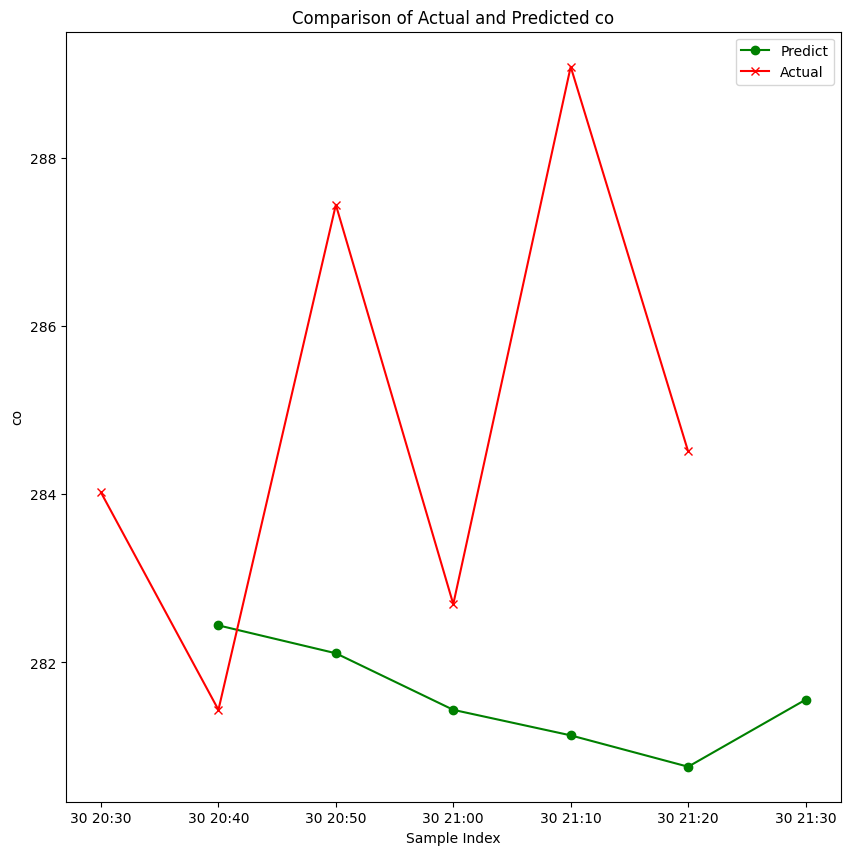

In [ ]:
last_timestamp_train = test_co.index[-6]
df_forecast_co = test_co.loc[:last_timestamp_train].copy()
# df_forecast_co.drop(columns='pred_co', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_co.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_co.columns, index=[new_timestamp])
    df_forecast_co = df_forecast_co.append(new_row)

    # create_lag(df_forecast_co, 'co')
    create_feature(df_forecast_co, 'co')
    data_to_predict = df_forecast_co.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_co.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediks


    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_co.at[new_timestamp, 'co'] = prediction_value


result_co = df_forecast_co.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_co['co'], label='Predict', color='green', marker='o')
plt.plot(test_co.loc[last_timestamp_train:].co, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted co')
plt.xlabel('Sample Index')
plt.ylabel('co')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].co, result_co['co'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].co, result_co['co'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].co, result_co['co']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].co, result_co['co'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 3.5166457519531207
Root Mean Squared Error (RMSE): 4.462928146084657
MAPE:  1.225904486173839 %


Fitting 3 folds for each of 216 candidates, totalling 648 fits
2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-26-1cb10d2b4345>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_co = df_forecast_co.append(new_row)
<ipython-input-26-1cb10d2b4345>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_co = df_forecast_co.append(new_row)
<ipython-input-26-1cb10d2b4345>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_co = df_forecast_co.append(new_row)
<ipython-input-26-1cb10d2b4345>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_co = df_forecast_co.append(new_row)
<ipython-input-26-1cb10d2b4345>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

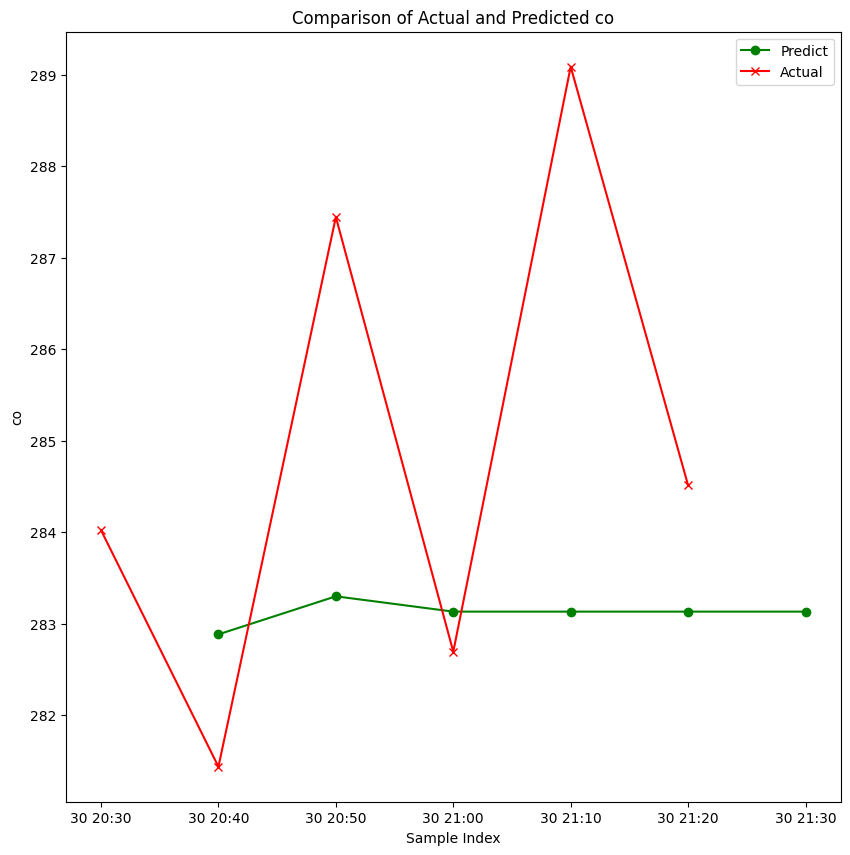

In [ ]:
param_grid_co = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}  # Sesuaikan param_grid

# # Grid Search untuk PM1
model_co = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid_co, cv=3, scoring='neg_mean_squared_error', verbose=1)
model_co.fit(X_train_copy_co, y_train_copy_co)

last_timestamp_train = test_co.index[-6]
df_forecast_co = test_co.loc[:last_timestamp_train].copy()
# df_forecast_co.drop(columns='pred_co', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_co.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_co.columns, index=[new_timestamp])
    df_forecast_co = df_forecast_co.append(new_row)

    # create_lag(df_forecast_co, 'co')
    create_feature(df_forecast_co, 'co')
    data_to_predict = df_forecast_co.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_co.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediks


    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_co.at[new_timestamp, 'co'] = prediction_value


result_co = df_forecast_co.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_co['co'], label='Predict', color='green', marker='o')
plt.plot(test_co.loc[last_timestamp_train:].co, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted co')
plt.xlabel('Sample Index')
plt.ylabel('co')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].co, result_co['co'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].co, result_co['co'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].co, result_co['co']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].co, result_co['co'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 2.5140189615885427
Root Mean Squared Error (RMSE): 3.1860299197465567
MAPE:  0.8770047368890125 %


**2. Memprediksi no2**

In [ ]:
X_train_copy_no2 = train_copy_no2.drop(columns=['no2'])
y_train_copy_no2 = train_copy_no2['no2']

In [ ]:
model_no2 =  xgb.XGBRegressor()
model_no2.fit(X_train_copy_no2, y_train_copy_no2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-30-e98cf9229cfa>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_no2 = df_forecast_no2.append(new_row)
<ipython-input-30-e98cf9229cfa>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_no2 = df_forecast_no2.append(new_row)
<ipython-input-30-e98cf9229cfa>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_no2 = df_forecast_no2.append(new_row)
<ipython-input-30-e98cf9229cfa>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_no2 = df_forecast_no2.append(new_row)
<ipython-input-30-e98cf9229cfa>:14: FutureWarning: The frame.append method is deprecated and will be removed from pa

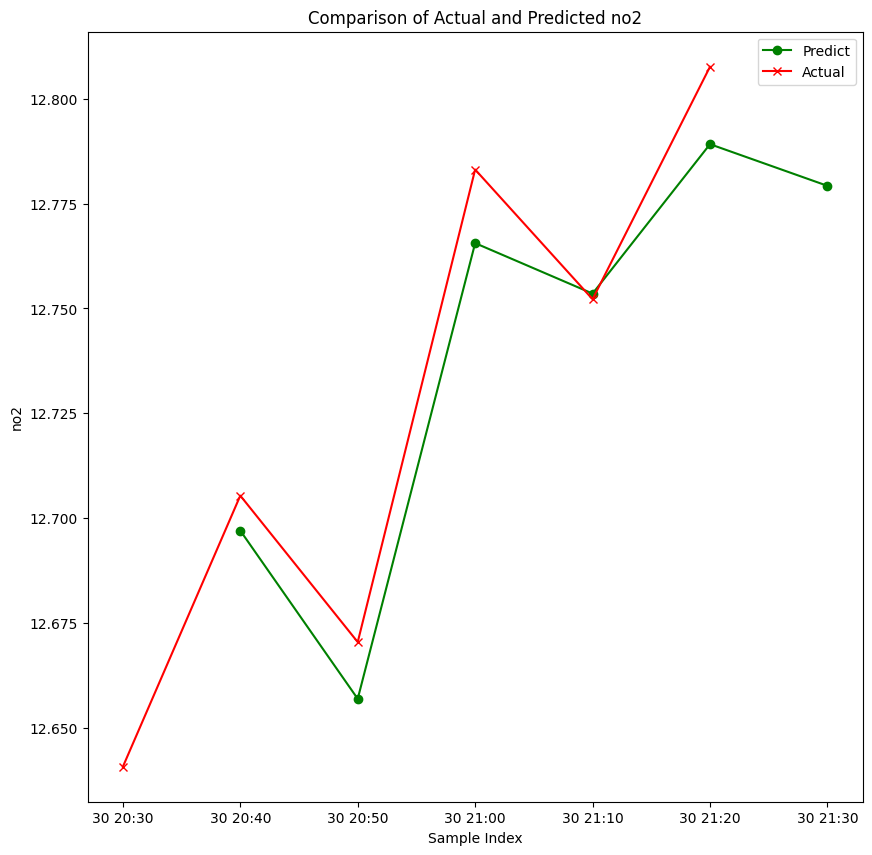

In [ ]:
last_timestamp_train = test_no2.index[-6]
df_forecast_no2 = test_no2.iloc[:-5].copy()
# df_forecast_no2.drop(columns='pred_no2', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_no2.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_no2.columns, index=[new_timestamp])
    df_forecast_no2 = df_forecast_no2.append(new_row)

    create_feature(df_forecast_no2, 'no2')
    data_to_predict = df_forecast_no2.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_no2.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediksi

    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_no2.at[new_timestamp, 'no2'] = prediction_value

result_no2 = df_forecast_no2.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_no2['no2'], label='Predict', color='green', marker='o')
plt.plot(test_no2.loc[last_timestamp_train:].no2, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted no2')
plt.xlabel('Sample Index')
plt.ylabel('no2')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].no2, result_no2['no2'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].no2, result_no2['no2'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].no2, result_no2['no2']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].no2, result_no2['no2'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 0.04910433731079067
Root Mean Squared Error (RMSE): 0.05414617585676327
MAPE:  0.3864940144302126 %


Fitting 3 folds for each of 216 candidates, totalling 648 fits
2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-32-90ec4f4b33a8>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_no2 = df_forecast_no2.append(new_row)
<ipython-input-32-90ec4f4b33a8>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_no2 = df_forecast_no2.append(new_row)
<ipython-input-32-90ec4f4b33a8>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_no2 = df_forecast_no2.append(new_row)
<ipython-input-32-90ec4f4b33a8>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_no2 = df_forecast_no2.append(new_row)
<ipython-input-32-90ec4f4b33a8>:27: FutureWarning: The frame.append method is deprecated and will be removed from pa

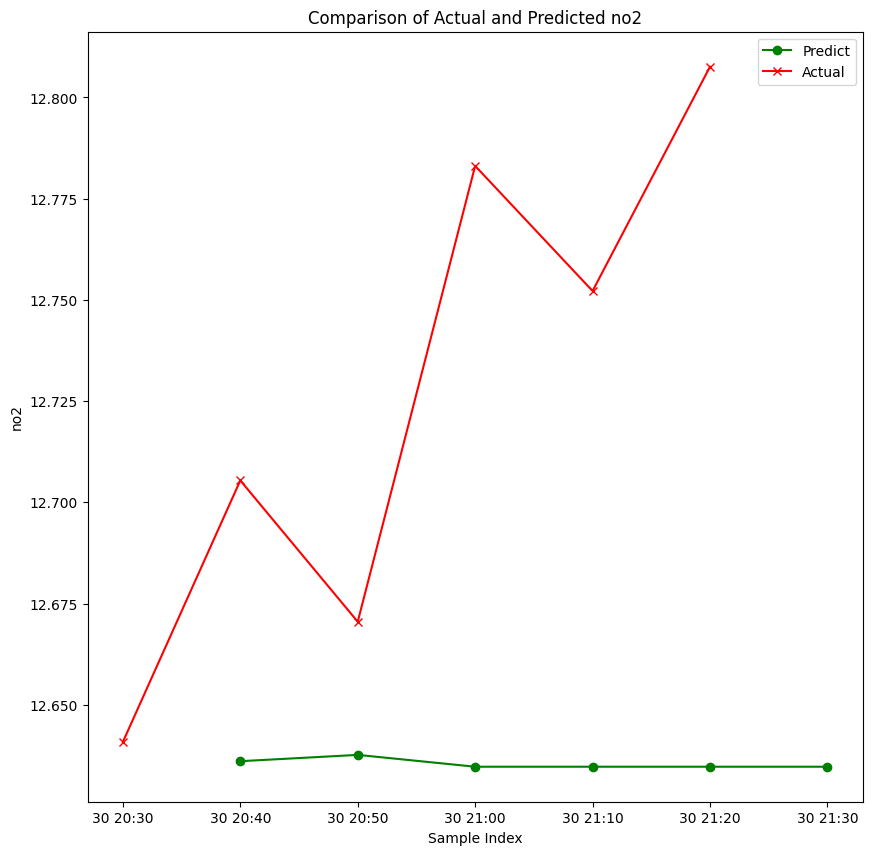

In [ ]:
param_grid_no2 = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}  # Sesuaikan param_grid

# Grid Search untuk PM1
model_no2 = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid_co, cv=3, scoring='neg_mean_squared_error', verbose=1)
model_no2.fit(X_train_copy_no2, y_train_copy_no2)

last_timestamp_train = test_no2.index[-6]
df_forecast_no2 = test_no2.iloc[:-5].copy()
# df_forecast_no2.drop(columns='pred_no2', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_no2.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_no2.columns, index=[new_timestamp])
    df_forecast_no2 = df_forecast_no2.append(new_row)

    create_feature(df_forecast_no2, 'no2')
    data_to_predict = df_forecast_no2.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_no2.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediksi

    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_no2.at[new_timestamp, 'no2'] = prediction_value

result_no2 = df_forecast_no2.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_no2['no2'], label='Predict', color='green', marker='o')
plt.plot(test_no2.loc[last_timestamp_train:].no2, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted no2')
plt.xlabel('Sample Index')
plt.ylabel('no2')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].no2, result_no2['no2'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].no2, result_no2['no2'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].no2, result_no2['no2']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].no2, result_no2['no2'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 0.09120558573404954
Root Mean Squared Error (RMSE): 0.10927268272022166
MAPE:  0.7144510717308037 %


**3. Memprediksi o3**

In [ ]:
X_train_copy_o3 = train_copy_o3.drop(columns=['o3'])
y_train_copy_o3 = train_copy_o3['o3']

In [ ]:
model_o3 =  xgb.XGBRegressor(learning_rate=0.1,n_estimators=300, )
model_o3.fit(X_train_copy_o3, y_train_copy_o3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-36-a13823e19a49>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_o3 = df_forecast_o3.append(new_row)
<ipython-input-36-a13823e19a49>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_o3 = df_forecast_o3.append(new_row)
<ipython-input-36-a13823e19a49>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_o3 = df_forecast_o3.append(new_row)
<ipython-input-36-a13823e19a49>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_o3 = df_forecast_o3.append(new_row)
<ipython-input-36-a13823e19a49>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

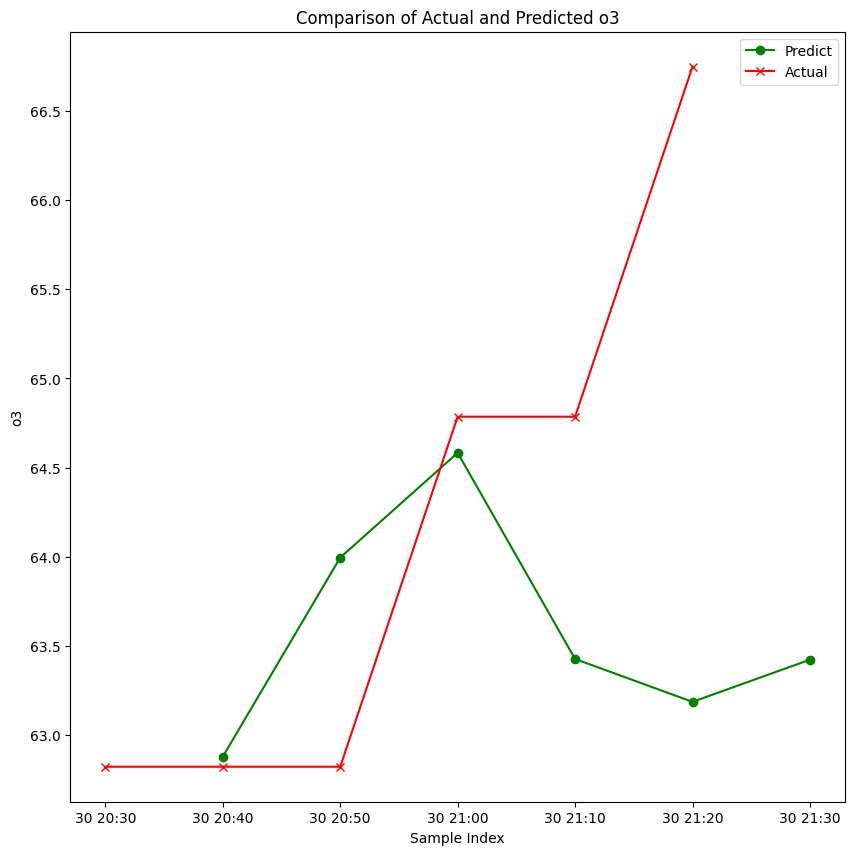

In [ ]:
last_timestamp_train = test_o3.index[-6]
df_forecast_o3 = test_o3.loc[:last_timestamp_train].copy()
# df_forecast_o3.drop(columns='pred_o3', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_o3.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_o3.columns, index=[new_timestamp])
    df_forecast_o3 = df_forecast_o3.append(new_row)

    # create_lag(df_forecast_co, 'co')
    create_feature(df_forecast_o3, 'o3')
    data_to_predict = df_forecast_o3.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_o3.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediks


    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_o3.at[new_timestamp, 'o3'] = prediction_value


result_o3 = df_forecast_o3.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_o3['o3'], label='Predict', color='green', marker='o')
plt.plot(test_o3.loc[last_timestamp_train:].o3, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted o3')
plt.xlabel('Sample Index')
plt.ylabel('o3')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].o3, result_o3['o3'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].o3, result_o3['o3'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].o3, result_o3['o3']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].o3, result_o3['o3'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 1.5457562784830767
Root Mean Squared Error (RMSE): 1.8233331997216171
MAPE:  2.3848391862098857 %


Fitting 3 folds for each of 216 candidates, totalling 648 fits
2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-38-d2421fc0915e>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_o3 = df_forecast_o3.append(new_row)
<ipython-input-38-d2421fc0915e>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_o3 = df_forecast_o3.append(new_row)
<ipython-input-38-d2421fc0915e>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_o3 = df_forecast_o3.append(new_row)
<ipython-input-38-d2421fc0915e>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_o3 = df_forecast_o3.append(new_row)
<ipython-input-38-d2421fc0915e>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

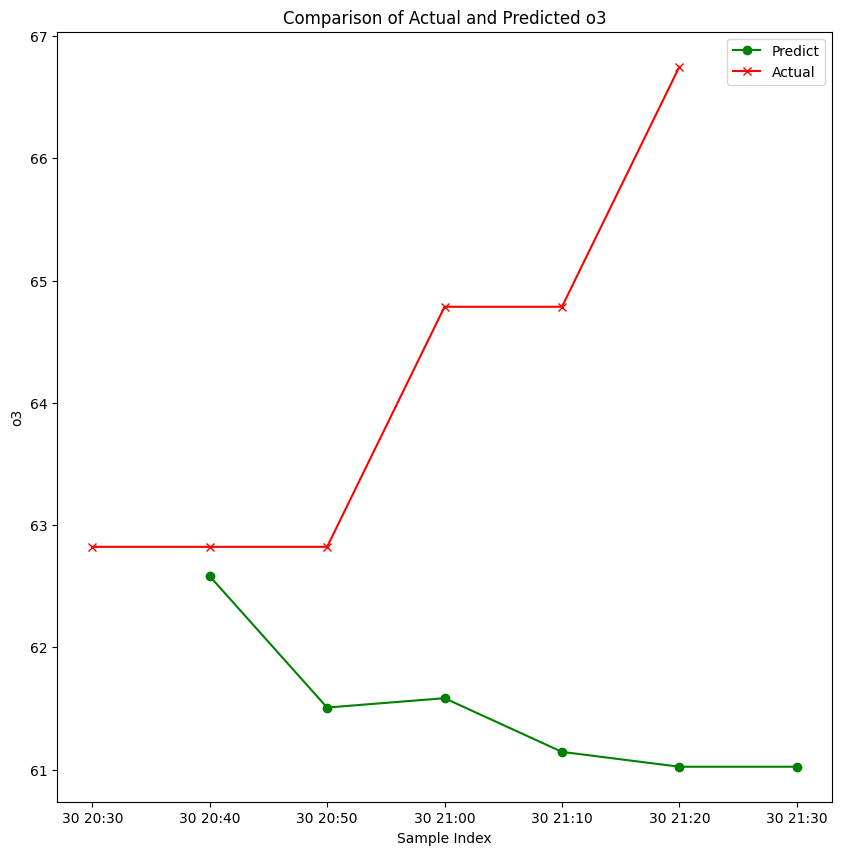

In [ ]:
param_grid_o3 = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}  # Sesuaikan param_grid

# Grid Search untuk PM1
model_o3 = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid_o3, cv=3, scoring='neg_mean_squared_error', verbose=1)
model_o3.fit(X_train_copy_o3, y_train_copy_o3)

last_timestamp_train = test_o3.index[-6]
df_forecast_o3 = test_o3.loc[:last_timestamp_train].copy()
# df_forecast_o3.drop(columns='pred_o3', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_o3.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_o3.columns, index=[new_timestamp])
    df_forecast_o3 = df_forecast_o3.append(new_row)

    # create_lag(df_forecast_co, 'co')
    create_feature(df_forecast_o3, 'o3')
    data_to_predict = df_forecast_o3.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_o3.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediks


    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_o3.at[new_timestamp, 'o3'] = prediction_value


result_o3 = df_forecast_o3.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_o3['o3'], label='Predict', color='green', marker='o')
plt.plot(test_o3.loc[last_timestamp_train:].o3, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted o3')
plt.xlabel('Sample Index')
plt.ylabel('o3')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].o3, result_o3['o3'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].o3, result_o3['o3'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].o3, result_o3['o3']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].o3, result_o3['o3'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 2.652922247314456
Root Mean Squared Error (RMSE): 3.252817811562617
MAPE:  4.074072226441499 %


**4. Memprediksi pm1**

In [ ]:
X_train_copy_pm1 = train_copy_pm1.drop(columns=['pm1'])
y_train_copy_pm1 = train_copy_pm1['pm1']

In [ ]:
model_pm1 =  xgb.XGBRegressor()
model_pm1.fit(X_train_copy_pm1, y_train_copy_pm1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-42-277a1eb5b616>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm1 = df_forecast_pm1.append(new_row)
<ipython-input-42-277a1eb5b616>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm1 = df_forecast_pm1.append(new_row)
<ipython-input-42-277a1eb5b616>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm1 = df_forecast_pm1.append(new_row)
<ipython-input-42-277a1eb5b616>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm1 = df_forecast_pm1.append(new_row)
<ipython-input-42-277a1eb5b616>:14: FutureWarning: The frame.append method is deprecated and will be removed from pa

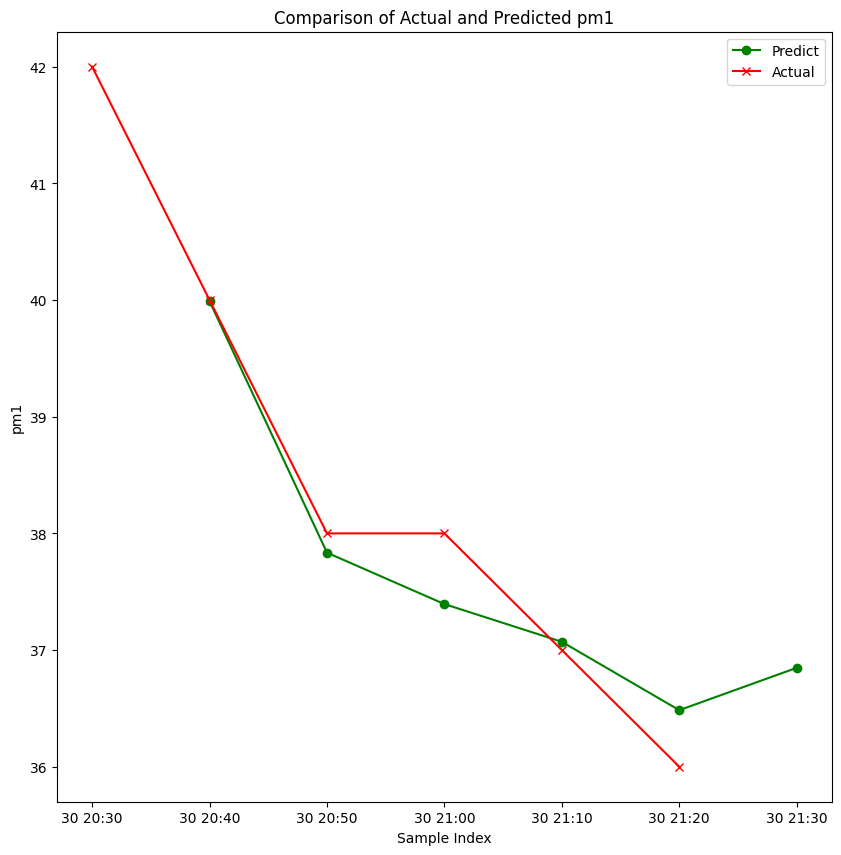

In [ ]:
last_timestamp_train = test_pm1.index[-6]
df_forecast_pm1 = test_pm1.loc[:last_timestamp_train].copy()
# df_forecast_pm1.drop(columns='pred_pm1', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_pm1.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_pm1.columns, index=[new_timestamp])
    df_forecast_pm1 = df_forecast_pm1.append(new_row)

    # create_lag(df_forecast_co, 'co')
    create_feature(df_forecast_pm1, 'pm1')
    data_to_predict = df_forecast_pm1.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_pm1.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediks


    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_pm1.at[new_timestamp, 'pm1'] = prediction_value


result_pm1 = df_forecast_pm1.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_pm1['pm1'], label='Predict', color='green', marker='o')
plt.plot(test_pm1.loc[last_timestamp_train:].pm1, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted pm1')
plt.xlabel('Sample Index')
plt.ylabel('pm1')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].pm1, result_pm1['pm1'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].pm1, result_pm1['pm1'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].pm1, result_pm1['pm1']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].pm1, result_pm1['pm1'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 1.178873062133789
Root Mean Squared Error (RMSE): 1.3504795808058443
MAPE:  2.9976158940174 %


Fitting 3 folds for each of 216 candidates, totalling 648 fits
2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-44-5d9df5c0d871>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm1 = df_forecast_pm1.append(new_row)
<ipython-input-44-5d9df5c0d871>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm1 = df_forecast_pm1.append(new_row)
<ipython-input-44-5d9df5c0d871>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm1 = df_forecast_pm1.append(new_row)
<ipython-input-44-5d9df5c0d871>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm1 = df_forecast_pm1.append(new_row)
<ipython-input-44-5d9df5c0d871>:27: FutureWarning: The frame.append method is deprecated and will be removed from pa

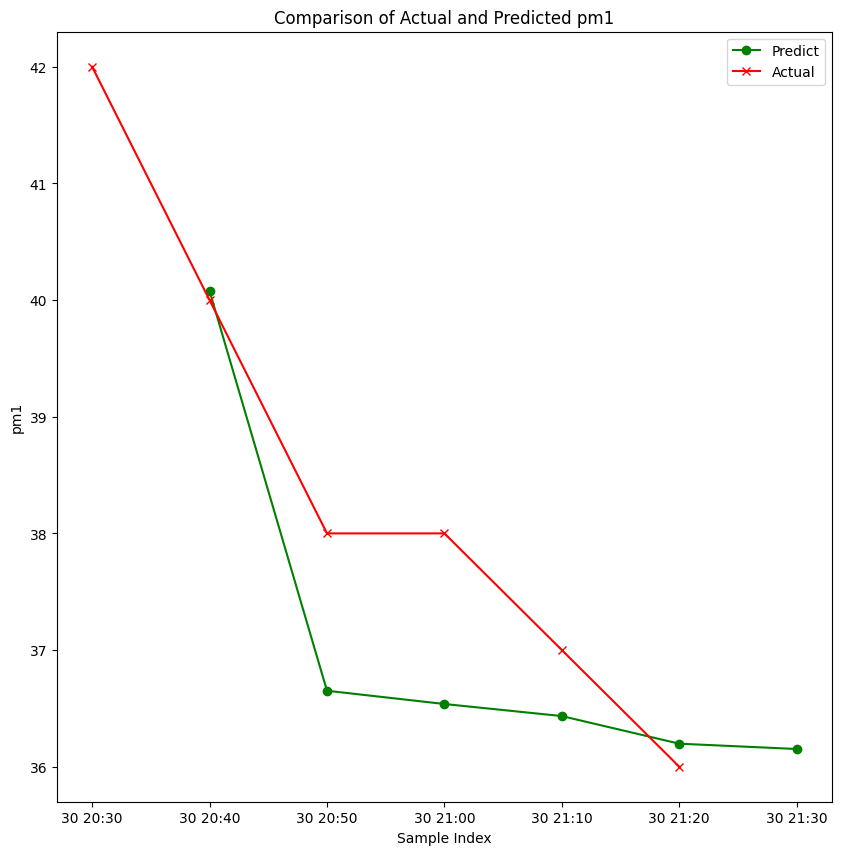

In [ ]:
param_grid_pm1 = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}  # Sesuaikan param_grid

# Grid Search untuk PM1
model_pm1 = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid_pm1, cv=3, scoring='neg_mean_squared_error', verbose=1)
model_pm1.fit(X_train_copy_pm1, y_train_copy_pm1)

last_timestamp_train = test_pm1.index[-6]
df_forecast_pm1 = test_pm1.loc[:last_timestamp_train].copy()
# df_forecast_pm1.drop(columns='pred_pm1', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_pm1.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_pm1.columns, index=[new_timestamp])
    df_forecast_pm1 = df_forecast_pm1.append(new_row)

    # create_lag(df_forecast_co, 'co')
    create_feature(df_forecast_pm1, 'pm1')
    data_to_predict = df_forecast_pm1.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_pm1.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediks


    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_pm1.at[new_timestamp, 'pm1'] = prediction_value


result_pm1 = df_forecast_pm1.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_pm1['pm1'], label='Predict', color='green', marker='o')
plt.plot(test_pm1.loc[last_timestamp_train:].pm1, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted pm1')
plt.xlabel('Sample Index')
plt.ylabel('pm1')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].pm1, result_pm1['pm1'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].pm1, result_pm1['pm1'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].pm1, result_pm1['pm1']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].pm1, result_pm1['pm1'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 1.542275110880534
Root Mean Squared Error (RMSE): 1.8333402294493983
MAPE:  3.918104755871002 %


**5.Memprediksi pm2_5**

In [ ]:
X_train_copy_pm25 = train_copy_pm25.drop(columns=['pm2_5'])
y_train_copy_pm25 = train_copy_pm25['pm2_5']

In [ ]:
model_pm25 =  xgb.XGBRegressor()
model_pm25.fit(X_train_copy_pm25, y_train_copy_pm25)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-48-d94fa345769b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm25 = df_forecast_pm25.append(new_row)
<ipython-input-48-d94fa345769b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm25 = df_forecast_pm25.append(new_row)
<ipython-input-48-d94fa345769b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm25 = df_forecast_pm25.append(new_row)
<ipython-input-48-d94fa345769b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm25 = df_forecast_pm25.append(new_row)
<ipython-input-48-d94fa345769b>:14: FutureWarning: The frame.append method is deprecated and will be removed

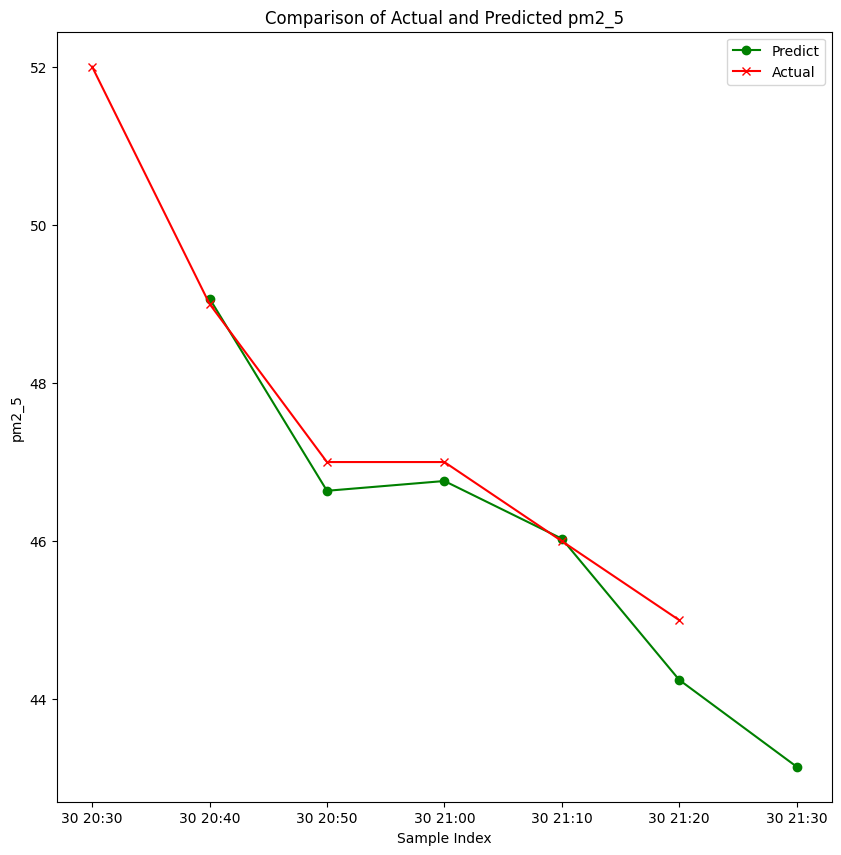

In [ ]:
last_timestamp_train = test_pm25.index[-6]
df_forecast_pm25 = test_pm25.loc[:last_timestamp_train].copy()
# df_forecast_pm25.drop(columns='pred_pm25', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_pm25.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_pm25.columns, index=[new_timestamp])
    df_forecast_pm25 = df_forecast_pm25.append(new_row)

    # create_lag(df_forecast_co, 'co')
    create_feature(df_forecast_pm25, 'pm2_5')
    data_to_predict = df_forecast_pm25.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_pm25.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediks


    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_pm25.at[new_timestamp, 'pm2_5'] = prediction_value


result_pm25 = df_forecast_pm25.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_pm25['pm2_5'], label='Predict', color='green', marker='o')
plt.plot(test_pm25.loc[last_timestamp_train:].pm2_5, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted pm2_5')
plt.xlabel('Sample Index')
plt.ylabel('pm2_5')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].pm2_5, result_pm25['pm2_5'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].pm2_5, result_pm25['pm2_5'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].pm2_5, result_pm25['pm2_5']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].pm2_5, result_pm25['pm2_5'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 1.6855570475260417
Root Mean Squared Error (RMSE): 1.9015875587157023
MAPE:  3.494856682620439 %


Fitting 3 folds for each of 216 candidates, totalling 648 fits
2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-52-bf88df4ee187>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm25 = df_forecast_pm25.append(new_row)
<ipython-input-52-bf88df4ee187>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm25 = df_forecast_pm25.append(new_row)
<ipython-input-52-bf88df4ee187>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm25 = df_forecast_pm25.append(new_row)
<ipython-input-52-bf88df4ee187>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm25 = df_forecast_pm25.append(new_row)
<ipython-input-52-bf88df4ee187>:27: FutureWarning: The frame.append method is deprecated and will be removed

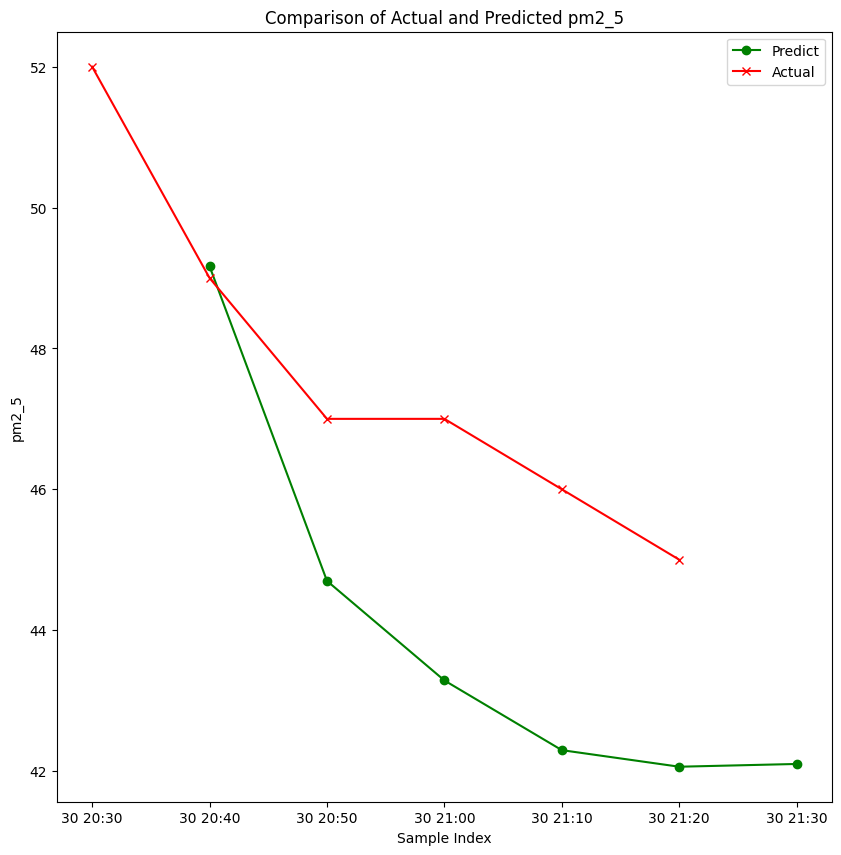

In [ ]:
param_grid_pm25 = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}  # Sesuaikan param_grid

# Grid Search untuk PM1
model_pm25 = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid_pm25, cv=3, scoring='neg_mean_squared_error', verbose=1)
model_pm25.fit(X_train_copy_pm25, y_train_copy_pm25)

last_timestamp_train = test_pm25.index[-6]
df_forecast_pm25 = test_pm25.loc[:last_timestamp_train].copy()
# df_forecast_pm25.drop(columns='pred_pm25', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_pm25.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_pm25.columns, index=[new_timestamp])
    df_forecast_pm25 = df_forecast_pm25.append(new_row)

    # create_lag(df_forecast_co, 'co')
    create_feature(df_forecast_pm25, 'pm2_5')
    data_to_predict = df_forecast_pm25.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_pm25.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediks


    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_pm25.at[new_timestamp, 'pm2_5'] = prediction_value


result_pm25 = df_forecast_pm25.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_pm25['pm2_5'], label='Predict', color='green', marker='o')
plt.plot(test_pm25.loc[last_timestamp_train:].pm2_5, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted pm2_5')
plt.xlabel('Sample Index')
plt.ylabel('pm2_5')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].pm2_5, result_pm25['pm2_5'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].pm2_5, result_pm25['pm2_5'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].pm2_5, result_pm25['pm2_5']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].pm2_5, result_pm25['pm2_5'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 3.7320143381754556
Root Mean Squared Error (RMSE): 3.794283595975003
MAPE:  7.857681497592327 %


**6.Memprediksi pm10**

In [ ]:
X_train_copy_pm10 = train_copy_pm10.drop(columns=['pm10'])
y_train_copy_pm10 = train_copy_pm10['pm10']

In [ ]:
model_pm10 =  xgb.XGBRegressor()
model_pm10.fit(X_train_copy_pm10, y_train_copy_pm10)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-56-bcdc2373bb54>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm10 = df_forecast_pm10.append(new_row)
<ipython-input-56-bcdc2373bb54>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm10 = df_forecast_pm10.append(new_row)
<ipython-input-56-bcdc2373bb54>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm10 = df_forecast_pm10.append(new_row)
<ipython-input-56-bcdc2373bb54>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm10 = df_forecast_pm10.append(new_row)
<ipython-input-56-bcdc2373bb54>:14: FutureWarning: The frame.append method is deprecated and will be removed

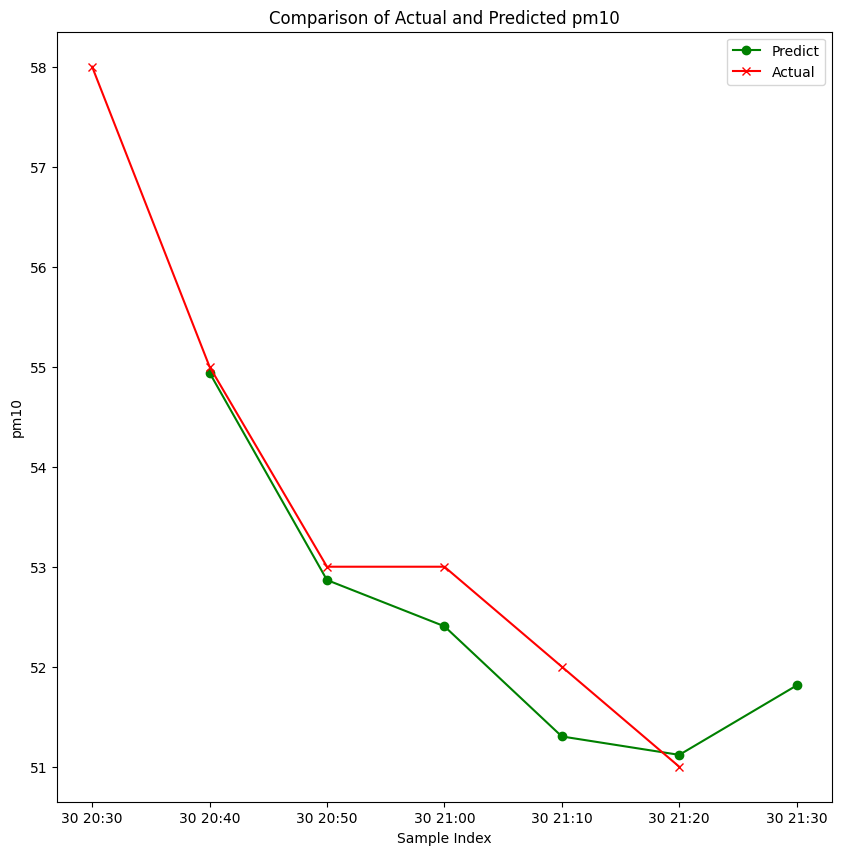

In [ ]:
last_timestamp_train = test_pm10.index[-6]
df_forecast_pm10 = test_pm10.loc[:last_timestamp_train].copy()
# df_forecast_pm10.drop(columns='pred_pm10', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_pm10.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_pm10.columns, index=[new_timestamp])
    df_forecast_pm10 = df_forecast_pm10.append(new_row)

    # create_lag(df_forecast_co, 'co')
    create_feature(df_forecast_pm10, 'pm10')
    data_to_predict = df_forecast_pm10.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_pm10.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediks


    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_pm10.at[new_timestamp, 'pm10'] = prediction_value


result_pm10 = df_forecast_pm10.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_pm10['pm10'], label='Predict', color='green', marker='o')
plt.plot(test_pm10.loc[last_timestamp_train:].pm10, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted pm10')
plt.xlabel('Sample Index')
plt.ylabel('pm10')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].pm10, result_pm10['pm10'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].pm10, result_pm10['pm10'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].pm10, result_pm10['pm10']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].pm10, result_pm10['pm10'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 1.5300712585449219
Root Mean Squared Error (RMSE): 1.7601084875449424
MAPE:  2.7949306118701096 %


Fitting 3 folds for each of 216 candidates, totalling 648 fits
2023-11-30 20:40:00
2023-11-30 20:50:00
2023-11-30 21:00:00
2023-11-30 21:10:00
2023-11-30 21:20:00
2023-11-30 21:30:00


<ipython-input-58-fa0fb6a14708>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm10 = df_forecast_pm10.append(new_row)
<ipython-input-58-fa0fb6a14708>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm10 = df_forecast_pm10.append(new_row)
<ipython-input-58-fa0fb6a14708>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm10 = df_forecast_pm10.append(new_row)
<ipython-input-58-fa0fb6a14708>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast_pm10 = df_forecast_pm10.append(new_row)
<ipython-input-58-fa0fb6a14708>:27: FutureWarning: The frame.append method is deprecated and will be removed

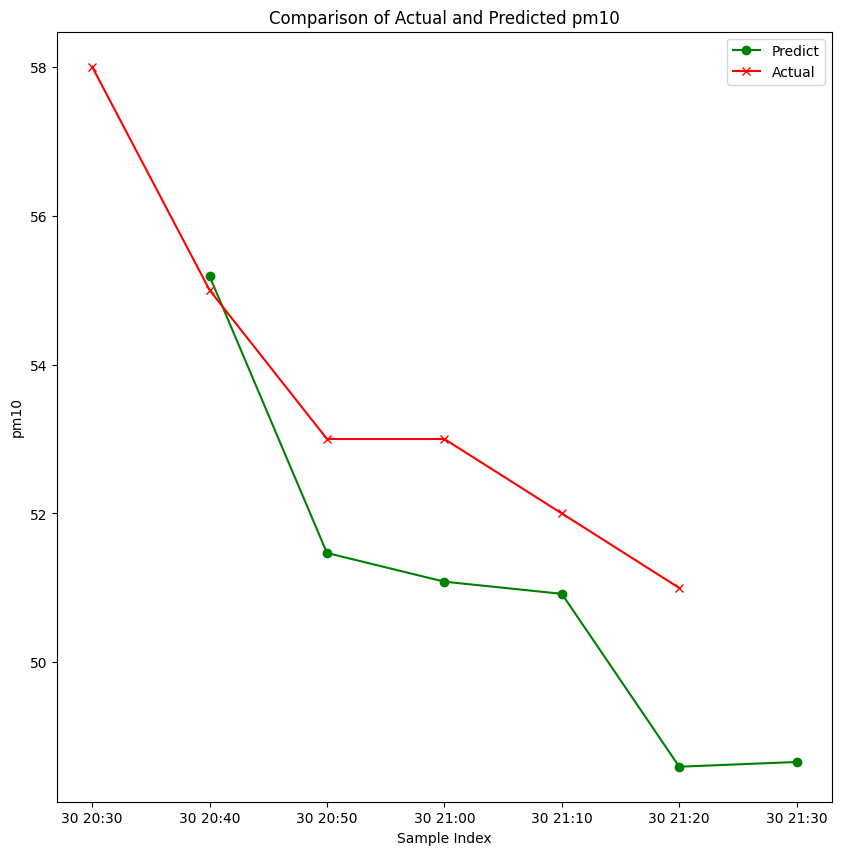

In [ ]:
param_grid_pm10= {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}  # Sesuaikan param_grid

# Grid Search untuk PM1
model_pm10 = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid_pm10, cv=3, scoring='neg_mean_squared_error', verbose=1)
model_pm10.fit(X_train_copy_pm10, y_train_copy_pm10)

last_timestamp_train = test_pm10.index[-6]
df_forecast_pm10 = test_pm10.loc[:last_timestamp_train].copy()
# df_forecast_pm10.drop(columns='pred_pm10', inplace=True)


for i in range(1, 7):
    last_row = df_forecast_pm10.iloc[-1]
    last_timestamp = last_row.name
    new_timestamp = last_timestamp + pd.Timedelta(minutes=10)
    print(new_timestamp)

    # Buat baris baru dengan index berikutnya yang memiliki nilai sama dengan baris terakhir
    new_row = pd.DataFrame(columns=df_forecast_pm10.columns, index=[new_timestamp])
    df_forecast_pm10 = df_forecast_pm10.append(new_row)

    # create_lag(df_forecast_co, 'co')
    create_feature(df_forecast_pm10, 'pm10')
    data_to_predict = df_forecast_pm10.iloc[-1].values[1:].reshape(1, -1)

    # Lakukan prediksi dengan model grid_search_co
    prediction = model_pm10.predict(data_to_predict)
    prediction_value = prediction[0]  # Ambil nilai prediksi dari array hasil prediks


    # Masukkan hasil prediksi ke dalam kolom 'co' di baris terakhir DataFrame
    df_forecast_pm10.at[new_timestamp, 'pm10'] = prediction_value


result_pm10 = df_forecast_pm10.iloc[-6:]

plt.figure(figsize=(10,10))
plt.plot(result_pm10['pm10'], label='Predict', color='green', marker='o')
plt.plot(test_pm10.loc[last_timestamp_train:].pm10, label='Actual', color='red',  linestyle='-', marker='x')
plt.title('Comparison of Actual and Predicted pm10')
plt.xlabel('Sample Index')
plt.ylabel('pm10')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test.loc[last_timestamp_train:].pm10, result_pm10['pm10'])
mse = mean_squared_error(df_test.loc[last_timestamp_train:].pm10, result_pm10['pm10'])
rmse = np.sqrt(mean_squared_error(df_test.loc[last_timestamp_train:].pm10, result_pm10['pm10']))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = y_true != 0  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true[non_zero_index] - y_pred[non_zero_index]) / y_true[non_zero_index])) * 100

mape = mean_absolute_percentage_error(df_test.loc[last_timestamp_train:].pm10, result_pm10['pm10'])
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print("MAPE: ", mape, "%")

Mean Absolute Error (MAE): 2.6799132029215493
Root Mean Squared Error (RMSE): 2.7512026207927494
MAPE:  4.9892109393075925 %


In [ ]:
result_pm10

,pm10,lag_1,lag_2,lag_3,pm10_rolling_mean,pm10_rolling_std,hour,dayofweek,quarter,month,year,minute,dayofyear,dayofmonth
2023-11-30 20:40:00,55.187134,58.000000,55.000000,51.000000,54.666667,3.511885,20,3,4,11,2023,40,334,30
2023-11-30 20:50:00,51.469048,55.187134,58.000000,55.000000,56.062378,1.680637,20,3,4,11,2023,50,334,30
2023-11-30 21:00:00,51.083553,51.469048,55.187134,58.000000,54.885394,3.275915,21,3,4,11,2023,0,334,30
2023-11-30 21:10:00,50.920345,51.083553,51.469048,55.187134,52.579912,2.266133,21,3,4,11,2023,10,334,30
2023-11-30 21:20:00,48.598312,50.920345,51.083553,51.469048,51.157649,0.281755,21,3,4,11,2023,20,334,30
2023-11-30 21:30:00,48.662128,48.598312,50.920345,51.083553,50.200737,1.390138,21,3,4,11,2023,30,334,30


### Save Model

In [ ]:
last_timestamp_train

In [ ]:
df_forecast_o3.tail(30)

In [ ]:
import joblib

# save model with joblib
filename_co = 'reg_co_model.sav'
joblib.dump(model_co, filename_co)

# filename_no2 = 'reg_no2_model.sav'
# joblib.dump(reg_no2, filename_no2)

# filename_o3 = 'reg_o3_model.sav'
# joblib.dump(reg_o3, filename_o3)

# filename_pm1 = 'reg_pm1_model.sav'
# joblib.dump(reg_pm1, filename_pm1)

# filename_pm25 = 'reg_pm25_model.sav'
# joblib.dump(reg_pm25, filename_pm25)

# filename_pm10 = 'reg_pm10_model.sav'
# joblib.dump(reg_pm10, filename_pm10)

In [ ]:
import pickle
with open('reg_co_model.sav', 'rb') as file:
    reg_co_model = pickle.load(file)


In [ ]:
reg_co_model.predict(X_train_copy_co)